#**Modelo predictivo de ventas por item**

***Note: This notebook is documented in Spanish.***

***The project README provides a full exlplanation of the workflow and conclusions in English.***

Ahora con los datos que tenemos podemos trabajarlos de forma conveniente e inteligente para entrenar un modelo de machine learning para que nos diga un estimado de ventas por item en un día.

*Importantdo librerias importantes*

In [ ]:
!pip install pyedautils
!pip install holidays
!pip install scikit-learn
!pip install ephem

In [ ]:
from google.colab import files
uploaded = files.upload()
import pandas as pd
import numpy as np
from pyedautils.season import get_season
import holidays

*Importando el dataset limpio*

In [ ]:
data=pd.read_csv('clean_cafe_sales.csv')
display(data)

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,Digital Wallet,Takeaway,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11
...,...,...,...,...,...,...,...,...
9966,TXN_7672686,Coffee,2,2.0,4.0,Digital Wallet,Takeaway,2023-08-30
9967,TXN_9659401,Cookie,3,1.0,3.0,Digital Wallet,In-store,2023-06-02
9968,TXN_5255387,Coffee,4,2.0,8.0,Digital Wallet,In-store,2023-03-02
9969,TXN_7695629,Cookie,3,1.0,3.0,Digital Wallet,In-store,2023-12-02


Como podemos ver la estruvtura de este dataset no es conveniente para un modelo predictivo, pero podemos hacer que lo sea.

Vamos a hacer lo siguiente:


1.   Vamos a crear una nueva columna con la estación del año correspondiente a esa fecha.
2.   Vamos a quedarnos con el registro de total de ventas por día (no por transacción), vamos a tener menos datos, pero el dataset va a ser más estructurado.
3. Vamos a crear una columna que me diga si unas ventas cayeron en un día festivo o no
4. Vamos a crear y entrenar el modelo de ML

Posteriormente vamos a crear un modelo basico de ML para predecir ventas de un Item en concreto.

El modelo de ML que voy a utilizar Random Forest, debido a que es el que mejor se puede adaptar al caso de estudio que tenemos y si bien no es el más potente que existe sí es bastante confiable.


*Modificando el dataset convenientemente*

In [ ]:
data_model=data.groupby(["Transaction Date","Item","Price Per Unit","Location"]).agg({"Quantity":"sum","Total Spent":"sum"}).reset_index()
data_model["Transaction Date"]=pd.to_datetime(data_model["Transaction Date"])
data_model["Day_of_week"]=data_model["Transaction Date"].dt.day_name()
data_model["Station"]=data_model["Transaction Date"].apply(get_season)
holiday_EUA=holidays.US()
data_model["Holiday"]=data_model["Transaction Date"].isin(holiday_EUA).map({True:"Yes",False:"No"})
display(data_model)
name=["Day_of_week","Station","Holiday"]
for i in name:
  print(f"{i}: {data_model[i].unique()}")

,Transaction Date,Item,Price Per Unit,Location,Quantity,Total Spent,Day_of_week,Station,Holiday
0,2023-01-01,Cake,3.0,In-store,3,9.0,Sunday,Winter,No
1,2023-01-01,Cake,3.0,Takeaway,7,21.0,Sunday,Winter,No
2,2023-01-01,Coffee,2.0,In-store,7,14.0,Sunday,Winter,No
3,2023-01-01,Coffee,2.0,Takeaway,7,14.0,Sunday,Winter,No
4,2023-01-01,Cookie,1.0,Takeaway,4,4.0,Sunday,Winter,No
...,...,...,...,...,...,...,...,...,...
4696,2023-12-31,Sandwich,4.0,In-store,13,52.0,Sunday,Winter,No
4697,2023-12-31,Sandwich,4.0,Takeaway,2,8.0,Sunday,Winter,No
4698,2023-12-31,Smoothie,4.0,In-store,5,20.0,Sunday,Winter,No
4699,2023-12-31,Smoothie,4.0,Takeaway,4,16.0,Sunday,Winter,No


Day_of_week: ['Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']
Station: ['Winter' 'Spring' 'Summer' 'Fall']
Holiday: ['No']


Como podemos observar la columna de 'Holiday' nunca tiene días festivos, entonces podemos despreciarla para el modelo

*Liberias para el modelo de ML*

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

Queremos predecir la cantidad que se va a vender de un item. Para esto vamos a utilizar como parametros predictores las siguientes columnas:

1. Item
2. Price Per Unit
3. Location
4. Day_of_week
5. Station

Esas serían nuestras 'x' y nuestra 'y' sería Quantity

*Creando el modelo*

In [ ]:
#Primero vamos a pasar todos los datos en tipo str a numerico para que el modelo pueda trabajar con ello
col_str=["Item","Location","Day_of_week","Station"]
for i in col_str:
  data_model[i]=LabelEncoder().fit_transform(data_model[i])
#Ordenando el df de forma ascendente porque vamos a entrenar con datos pasados y luego futuros
data_model=data_model.sort_values(by="Transaction Date").reset_index(drop=True)
#Definimos quienes van a ser nuestra 'x' y nuestra 'y'
x=data_model[["Item","Price Per Unit","Location","Day_of_week","Station"]]
y=data_model["Quantity"]
#Definiendo cual va a ser el modelo que vamos a hacer
rf=RandomForestRegressor(random_state=42)
#Un modelo de ML tiene muchos parametros con los cuales puedes "jugar" para maximizar el rendimiento de tu modelo, es por eso que voy a usar 'GridSearch' que es
#una herramienta que nos ayuda a encontrar una zona lo suficientemente estable

parametros={
    'n_estimators':[100,200,300,400], #Numero de árboles del modelo
    'max_depth':[3,4,5,6,None], # Profundidad máxima de cada árbol
    'min_samples_split':[2,4,6], # Número mínimo de muestras necesarias para dividir un nodo interno
    'min_samples_leaf':[1,2,4] # Número mínimo de muestras necesarias en cada hoja del árbol
}

*Viendo la combinación optima de los parámetros*

Cabe aclarar que esta parte la saqué del bloque de código anterior porque es un procedimiento que está pensado para hacerse una vez, ya que consume muchos recursos. Es por eso que lo ponemos un un bloque de código por aparte, ya que si en el futuro hay un error de código se pueda arreglar sin necesidad de volver a correr esta parte que consume muchos recursos.

Por otra parte vamos a dividir en temporalidad el dataset, ya que no deberíamos usar el futuro para entrenar el modelo, entonces vamos a ordenarlo por antiguiedad y posteriormente dividir el train como el 80% de los datos más antiguos y el test como el 20% de los datos más recientes

In [ ]:
#Dividiendo los datos que van a ser para entrenar y para testear
lim_train=int(data_model.shape[0]*0.8)
x_train=x.iloc[:lim_train]
y_train=y.iloc[:lim_train]
x_test=x.iloc[lim_train:]
y_test=y.iloc[lim_train:]
#buscando los mejores parámetros
validacion=TimeSeriesSplit(n_splits=5) #Parametros para validar temporalmente el modelo
grdsrch=GridSearchCV(estimator=rf,param_grid=parametros,cv=validacion,scoring='r2',n_jobs=-1) #Aplicar parametros
grdsrch.fit(x_train,y_train) #El modelo se ajusta a los datos que tenemos y prueba las diferentes combinaciones que declaramos para ver cual obtiene un r^2 más alto

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 4, 5, 6, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300, 400]},
             scoring='r2')

*Mostrando los mejores resultados del modelo*

{'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 400}
[0.37131589 0.20127529 0.10797526 0.20961344 0.10982012]


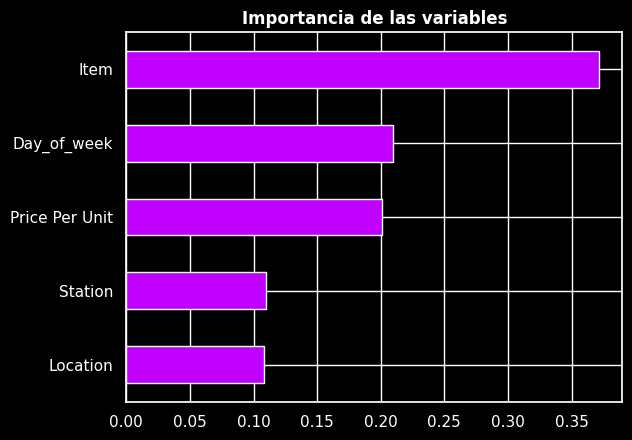

In [ ]:
#Viendo los mejores parametros
print(grdsrch.best_params_)
#Mostrando las variables más importantes del modelo
modelo=grdsrch.best_estimator_
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
print(modelo.feature_importances_)
plt.style.use("dark_background")
importancia_variables=pd.Series(modelo.feature_importances_,index=x.columns)
importancia_variables.sort_values().plot(kind="barh",color="#BF00FE")
plt.title("Importancia de las variables",color="white",weight="bold")
plt.show()

Podemos ver que lo que más afecta a las ventas es lo siguiente:
1. El producto
2. El día de la semana
3. El precio
4. La estación del año
5. Si se va a consumir dentro del establecimiento o si es para llevar


Lo único faltante es revisar si no hubo algún tipo de Overfitting o Underfitting. En caso de que no sea el caso podemos concluir y dejar una pequeña función con la cual podamos predecir las ventas esperadas de un producto mediante los parametros antes establecidos

*Viendo posibles fallas del modelo*

In [ ]:
#Prediciendo los datos que faltan (testeo)
y_pred=modelo.predict(x_test)
#Viendo el desempeño de predicción del modelo con r^2 y comparando con el 'root_mean_squared_error' (cuantas unidades tiene como falla el modelo al predecir)
r2=round((r2_score(y_test,y_pred))*100,4)
RMSE=round(root_mean_squared_error(y_test,y_pred),4)
print(f"R^2: {r2}%")
print(f"RMSE: {RMSE}")

R^2: 2.1611%
RMSE: 5.154


Podemos ver que el R² es Bajisimo, ahora voy a ver la media de la cantidad vendida para ver si se obtuvo un buen valor de RMSE

In [ ]:
media=round(data_model["Quantity"].mean(),4)
print(f"La media de las ventas es de {media}")

La media de las ventas es de 6.4157


Podemos ver que la media es de 6.4 unidades y nuestro error es de ± 5.15, por lo tanto es un error demasiado alto que no es aceptable

# **Conclusiones**

Podemos ver que el modelo tiene un desempeño bajo, debido a que el R² es 2.16% (casi 0), lo que quiere decir que, con los datos que tenemos, podemos predecir únicamente el 2.16% de la variabilidad de las ventas. Además, el modelo cuenta con un error de predicción de ±5.15. Esto puede sonar razonable hasta que nos damos cuenta de que el promedio de ventas es de 6.41, por lo que el modelo prácticamente no nos dice nada.

Este mal desempeño se puede atribuir casi totalmente a un underfitting, es decir, que el modelo no es capaz de capturar la relación entre X e Y (siendo X las variables que usamos para predecir y Y la variable que se quiere predecir). Esto tiene mucho sentido, ya que predecir un fenómeno tan complejo como las ventas de un producto requiere considerar muchos factores externos que, si bien pudieran parecer despreciables en una primera instancia, sí afectan en gran medida al modelo. Algunos de estos factores, que no se encuentran en el dataset, podrían ser los siguientes:

* Temperatura del día

* Tráfico

* Comportamiento de negocios que sean competencia

* Promociones de la tienda

* Eventos en la ciudad

* Disponibilidad de producto

* Incidentes cerca del local

Este tipo de factores no se encuentran en el dataset, y esa es probablemente la principal causa de que el modelo predictivo no haya tenido un desempeño sobresaliente.

Para futuros análisis de este tipo de fenómenos, se recomienda recolectar datos adicionales del día en el cual el negocio esté abierto, aunque estos no estén directamente relacionados con el negocio.